<a href="https://colab.research.google.com/github/Asymptote07/ANC/blob/main/ANC_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using CPU for computations
137500/137500 ━━━━━━━━━━━━━━━━━━━━ 4637s 34ms/step - loss: 0.0107
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 100, 128)       │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 100, 128)       │            512 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 100, 64)        │         24,640 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 50, 64)         │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50, 64)         │          4,160 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 64)         │          4,160 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 64)         │          4,160 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 50, 64)         │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3200)           │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │        102,432 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             33 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 421,317 (1.61 MB)

 Trainable params: 140,353 (548.25 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 280,708 (1.07 MB)

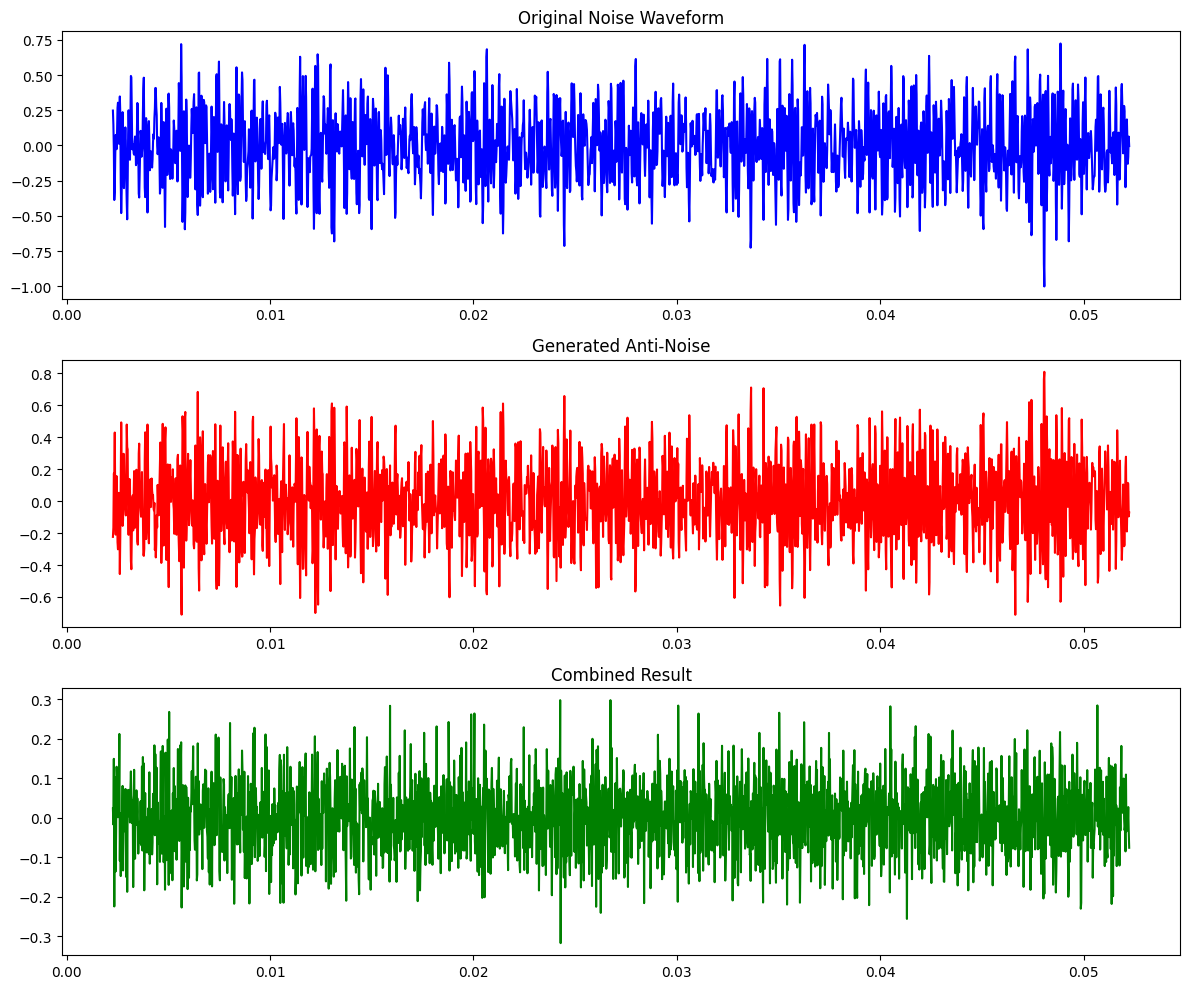


Original Noise Sample:



Cancellation Signal:



Processed Result:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

class NoiseCancellationEngine:
    """
    Urban noise cancellation system using deep learning waveform prediction.
    Generates synthetic noise patterns and learns to produce phase-inverted cancellation signals.
    """

    # System configuration parameters
    TRAINING_SAMPLES = 100       # Number of training waveforms
    AUDIO_DURATION = 1.0         # Seconds per sample
    SAMPLE_RATE = 44100          # Audio sampling rate (Hz)
    TRAINING_EPOCHS = 1          # Single training epoch
    LEARNING_RATE = 0.0001       # Model learning rate
    WINDOW_SIZE = 100            # Input sequence length
    MAX_FREQ = 10000             # Maximum noise frequency (Hz)
    BATCH_SIZE = 32              # Training batch size

    def __init__(self):
        """Initialize the noise cancellation system"""
        self.predictor = self._create_prediction_model()
        self._check_hardware_acceleration()

    def _check_hardware_acceleration(self):
        """Verify and enable GPU acceleration if available"""
        if tf.config.list_physical_devices('GPU'):
            print("GPU acceleration enabled")
        else:
            print("Using CPU for computations")

    def _generate_noise_profile(self):
        """
        Create synthetic urban noise with multiple frequency components
        Returns normalized waveform (-1 to 1) containing complex noise patterns
        """
        time_axis = np.linspace(0, self.AUDIO_DURATION,
                               int(self.SAMPLE_RATE * self.AUDIO_DURATION),
                               endpoint=False)

        # Generate harmonic components
        num_harmonics = np.random.randint(5, 20)
        frequencies = np.random.uniform(20, self.MAX_FREQ, num_harmonics)
        waveform = np.zeros_like(time_axis)

        # Add multiple frequency components
        for freq in frequencies:
            amplitude = np.random.uniform(0.1, 0.5)
            waveform += amplitude * np.sin(2 * np.pi * freq * time_axis)

        # Add broadband noise component
        noise_level = np.random.uniform(0.05, 0.1)
        waveform += noise_level * np.random.randn(len(time_axis))

        # Normalize output to prevent clipping
        return waveform / (np.max(np.abs(waveform)) + 1e-8)

    def _prepare_dataset(self):
        """Generate and format training data"""
        waveform_collection = np.array([self._generate_noise_profile()
                                      for _ in range(self.TRAINING_SAMPLES)])

        features, targets = [], []
        for wave in waveform_collection:
            for i in range(len(wave) - self.WINDOW_SIZE):
                features.append(wave[i:i + self.WINDOW_SIZE])
                targets.append(-wave[i + self.WINDOW_SIZE])  # Phase inversion target

        return (np.array(features).reshape(-1, self.WINDOW_SIZE, 1),
                np.array(targets))

    def _create_prediction_model(self):
        """Construct neural network with attention mechanism"""

        # Input layer processing audio windows
        input_layer = layers.Input(shape=(self.WINDOW_SIZE, 1))

        # Feature extraction
        conv1 = layers.Conv1D(128, 3, activation='relu', padding='same')(input_layer)
        norm1 = layers.BatchNormalization()(conv1)
        conv2 = layers.Conv1D(64, 3, activation='relu', padding='same')(norm1)
        pool1 = layers.MaxPooling1D(2)(conv2)

        # Attention mechanism
        query = layers.Dense(64, activation='relu')(pool1)
        key = layers.Dense(64, activation='relu')(pool1)
        value = layers.Dense(64, activation='relu')(pool1)
        attention = layers.Attention()([query, key, value])

        # Prediction head
        flat = layers.Flatten()(attention)
        dense = layers.Dense(32, activation='relu')(flat)
        output = layers.Dense(1)(dense)

        # Compile complete model
        model = models.Model(inputs=input_layer, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.LEARNING_RATE),
                     loss='mean_squared_error')
        return model

    def train_system(self):
        """Execute model training"""
        X, y = self._prepare_dataset()
        self.predictor.fit(X, y,
                          epochs=self.TRAINING_EPOCHS,
                          batch_size=self.BATCH_SIZE,
                          verbose=1)

    def generate_cancellation(self, input_wave):
        """Produce anti-noise waveform for given input"""
        segments = []
        for i in range(len(input_wave) - self.WINDOW_SIZE):
            segments.append(input_wave[i:i + self.WINDOW_SIZE])
        segments = np.array(segments).reshape(len(segments), self.WINDOW_SIZE, 1)
        return self.predictor.predict(segments).flatten()

    def demonstrate(self):
        """Run complete demonstration"""
        # Train the system
        self.train_system()

        # Generate test case
        test_wave = self._generate_noise_profile()
        anti_wave = self.generate_cancellation(test_wave)
        processed = test_wave[self.WINDOW_SIZE:] + anti_wave

        # Display model architecture
        self.predictor.summary()

        # Visualize results
        time_axis = np.linspace(0, self.AUDIO_DURATION,
                               int(self.SAMPLE_RATE * self.AUDIO_DURATION))[self.WINDOW_SIZE:]
        zoom = slice(0, int(0.05 * self.SAMPLE_RATE))  # First 50ms

        plt.figure(figsize=(12, 10))

        plt.subplot(3, 1, 1)
        plt.plot(time_axis[zoom], test_wave[self.WINDOW_SIZE:][zoom], 'b')
        plt.title("Original Noise Waveform")

        plt.subplot(3, 1, 2)
        plt.plot(time_axis[zoom], anti_wave[zoom], 'r')
        plt.title("Generated Anti-Noise")

        plt.subplot(3, 1, 3)
        plt.plot(time_axis[zoom], processed[zoom], 'g')
        plt.title("Combined Result")

        plt.tight_layout()
        plt.show()

        # Audio playback
        print("\nOriginal Noise Sample:")
        display(Audio(test_wave, rate=self.SAMPLE_RATE))
        print("\nCancellation Signal:")
        display(Audio(anti_wave, rate=self.SAMPLE_RATE))
        print("\nProcessed Result:")
        display(Audio(processed, rate=self.SAMPLE_RATE))

# Execute the demonstration
engine = NoiseCancellationEngine()
engine.demonstrate()